In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import math
import torch
import torchvision
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
import lbg_forecast.cosmology as cos
import lbg_forecast.priors_gp_csfrd as gp
import lbg_forecast.cosmology as cosmo

In [2]:
def inverse(x):
    return x**2
def forward(x):
    return np.sqrt(x)

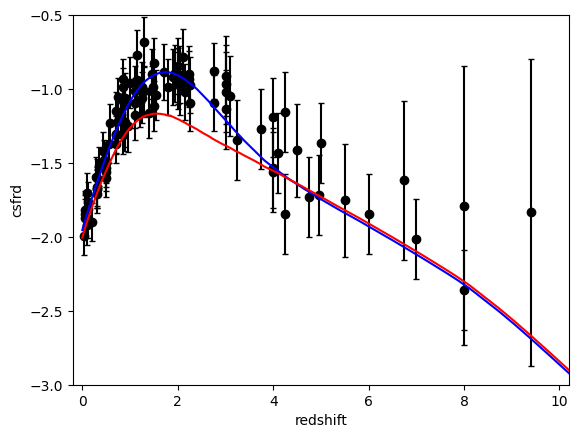

In [3]:
data = ascii.read("csfr_data/csfrs.dat")  

scale = np.array(data["Scale"])
redshift = cos.scale_to_z(scale)
total_obs_csfr = np.array(data["Total_Obs_CSFR"])
true_csfr = np.array(data["True_CSFR"])

plt.errorbar(redshift, np.log10(total_obs_csfr), zorder=1000, c="b")
plt.errorbar(redshift, np.log10(true_csfr), zorder=1000, c="r")
plt.xlim(-0.2, 10.2)
plt.ylim(-3, -0.5)

train_redshift, train_log_csfrd, train_log_shifted_csfrd, train_log_csfrd_errors = gp.get_training_data(True)

<ErrorbarContainer object of 3 artists>

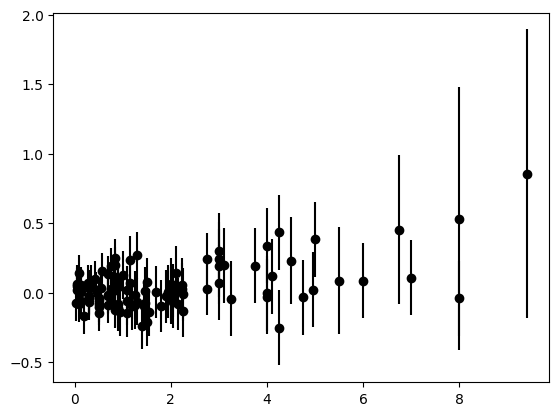

In [4]:
plt.errorbar(train_redshift, train_log_shifted_csfrd, train_log_csfrd_errors, fmt='ko')

In [5]:
model, likelihood = gp.create_gp_model(train_redshift, train_log_shifted_csfrd, train_log_csfrd_errors, [1.0, 7.0], [0.5, 100])
trained_model, trained_likelihood = gp.gp_training_loop(model, likelihood, train_redshift, train_log_shifted_csfrd, training_iter=10000, lr=0.1)

Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0
4.880029334427514
3.4722510158665547
2.2770374936347992
1.3356095205250984
0.6828874448843557
0.36708820368521544
0.2740764861801636
0.27016974758297085
0.2693223746143618
0.2685516435636151
0.26784558674634645
0.2671944852479813
0.2665903447232555
0.26602651508293834
0.2654974152651065
0.2649983283692045
0.2645252439634347
0.26407473347586913
0.2636438501159733
0.2632300478133505
0.2628311153010392
0.2624451224092956
0.2620703762394015
0.2617053853269385
0.2613488302533509
0.26099953945314125
0.26065646920430147
0.2603186869884915
0.25998535757036656
0.2596557312774416
0.2593291340677839
0.25900495905720533
0.2586826592444722
0.2583617412258474
0.25804175973189125
0.2577223128522299
0.2574030378398487
0.257083607406883
0.2567637264400494
0.25644312907668987
0.2561215760926533
0.25579885256143065
0.25547476575055417
0.2551491432266161
0.254821831

In [6]:
test_redshift = torch.linspace(0.001, 10, 200)
f_preds = gp.gp_evaluate_model(trained_model, test_redshift)

/var/folders/s9/j1tshp4s5019kbkk8hz2q9840000gn/T/ipykernel_27641/635526763.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x)


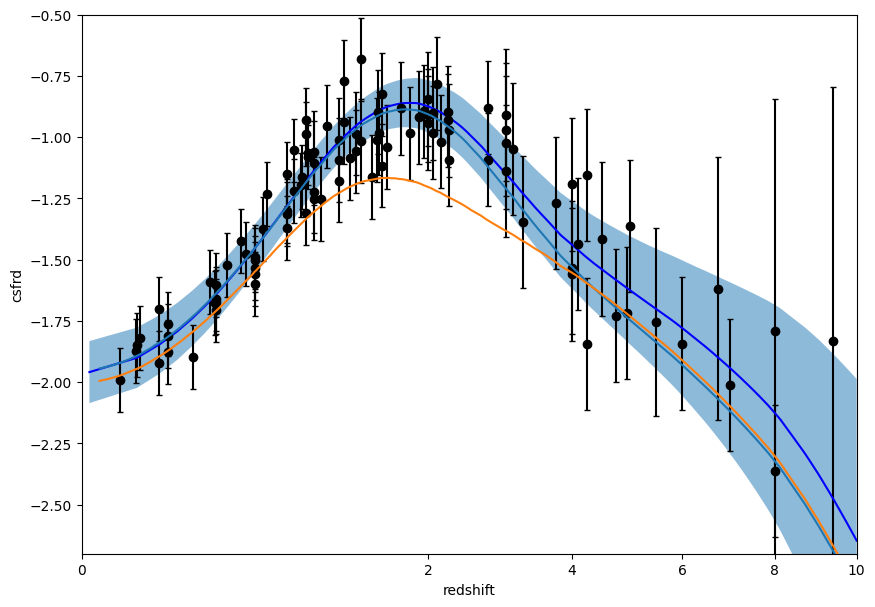

In [7]:
prospb = np.loadtxt("csfr_data/behroozi_19_sfrd.txt")
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    shift = gp.mean_obs_behroozi(test_redshift.numpy(), log=True)
    ax.errorbar(redshift, np.log10(total_obs_csfr), zorder=1000)
    ax.errorbar(redshift, np.log10(true_csfr), zorder=1000)

    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.errorbar(train_redshift.numpy(), train_log_csfrd.numpy(), yerr=train_log_csfrd_errors, fmt='ko', capsize=2)
    # Plot predictive means as blue line
    ax.plot(test_redshift.numpy(), f_preds.mean+shift, c='b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_redshift.numpy(), lower+shift, upper+shift, alpha=0.5)
    #ax.legend(['Observed Data', 'Mean', 'Confidence'])

    ax.set_xlabel("redshift")
    ax.set_ylabel("csfrd")
    ax.set_ylim(-2.7, -0.5)
    ax.set_xlim(-0.0, 10)
    ax.set_xscale('function', functions=(forward, inverse))

In [8]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: covar_module.raw_outputscale               value = -0.4168453017574082
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 6.476528513671747


/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/var/folders/s9/j1tshp4s5019kbkk8hz2q9840000gn/T/ipykernel_27641/635526763.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x)


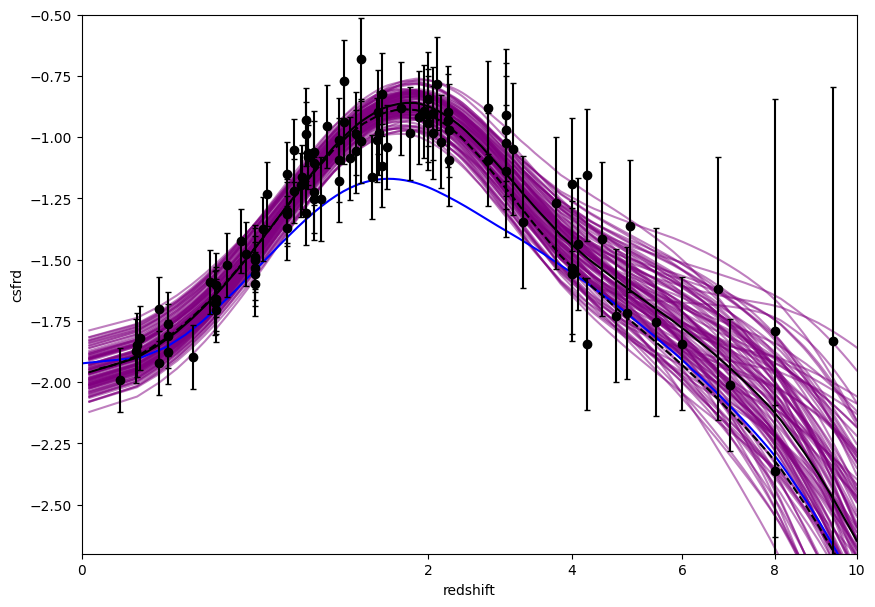

In [9]:
prospb = np.loadtxt("csfr_data/behroozi_19_sfrd.txt")
with torch.no_grad():

    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    nsamples = 100
    for sample in range(nsamples):
        f_sample = f_preds.sample()+shift
        #if((f_sample > 0.0).all()):
        ax.plot(test_redshift, f_sample, c='purple', alpha=0.5)
    ax.errorbar(redshift, np.log10(total_obs_csfr), zorder=1000, ls='--', c='k')
    ax.plot(test_redshift, f_preds.mean+shift, zorder=1000, ls='-', c='k')
    ax.plot(prospb[:, 0], np.log10(prospb[:, 2]), c='b')
    ax.errorbar(train_redshift.numpy(), train_log_csfrd.numpy(), yerr=train_log_csfrd_errors, fmt='ko', capsize=2)
    
    ax.set_xlabel("redshift")
    ax.set_ylabel("csfrd")
    ax.set_ylim(-2.7, -0.5)
    ax.set_xlim(-0.0, 10)
    ax.set_xscale('function', functions=(forward, inverse))

/var/folders/s9/j1tshp4s5019kbkk8hz2q9840000gn/T/ipykernel_27641/635526763.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x)


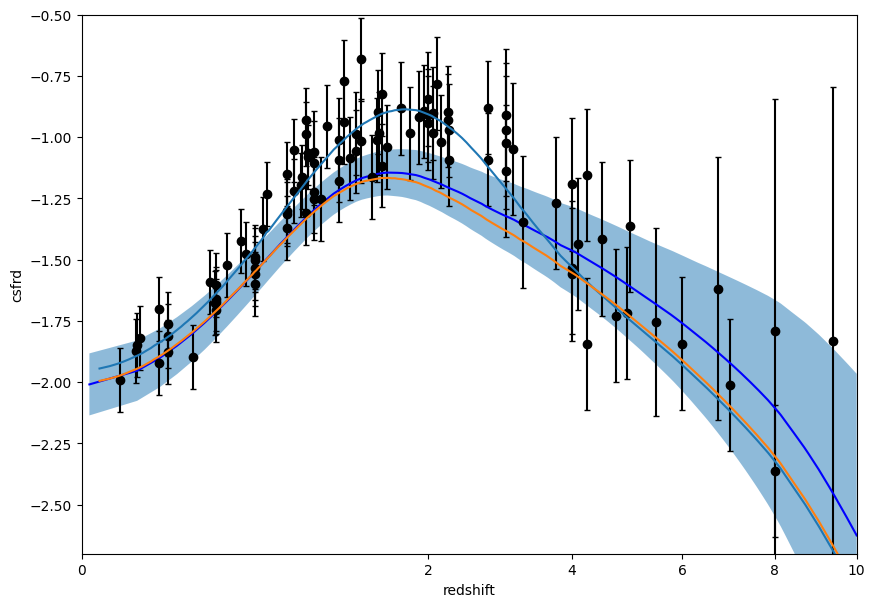

In [10]:
prospb = np.loadtxt("csfr_data/behroozi_19_sfrd.txt")
sys_shift = gp.systematic_shift(test_redshift)
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(10, 7))


    ax.errorbar(redshift, np.log10(total_obs_csfr), zorder=1000)
    ax.errorbar(redshift, np.log10(true_csfr), zorder=1000)

    # Get upper and lower confidence bounds
    lower, upper = f_preds.confidence_region()
    # Plot training data as black stars
    ax.errorbar(train_redshift.numpy(), train_log_csfrd.numpy(), yerr=train_log_csfrd_errors, fmt='ko', capsize=2)
    # Plot predictive means as blue line
    ax.plot(test_redshift.numpy(), f_preds.mean+shift-sys_shift, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_redshift.numpy(), lower+shift-sys_shift, upper+shift-sys_shift, alpha=0.5)

    ax.set_xlabel("redshift")
    ax.set_ylabel("csfrd")
    ax.set_ylim(-2.7, -0.5)
    ax.set_xlim(-0.0, 10)
    ax.set_xscale('function', functions=(forward, inverse))

/var/folders/s9/j1tshp4s5019kbkk8hz2q9840000gn/T/ipykernel_27641/635526763.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x)


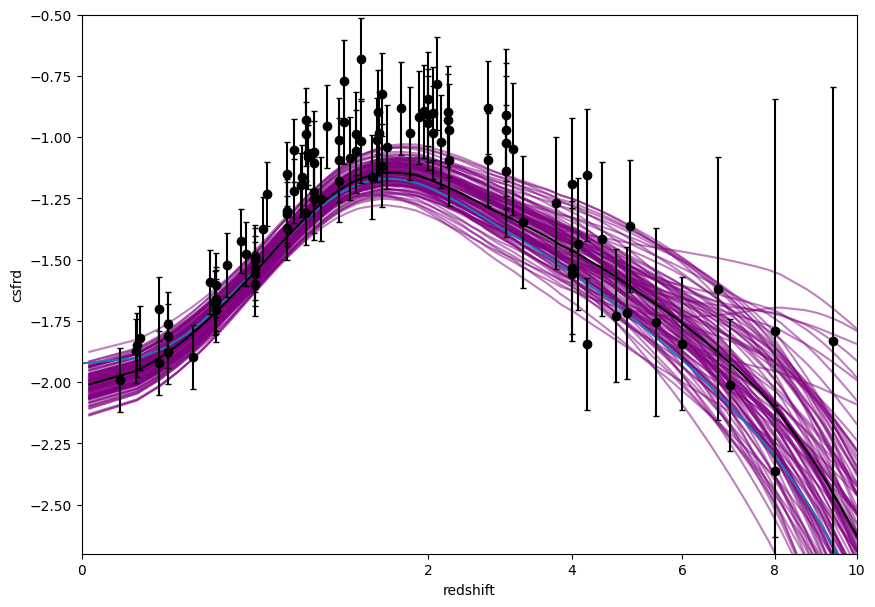

In [11]:
prospb = np.loadtxt("csfr_data/behroozi_19_sfrd.txt")
with torch.no_grad():

    f, ax = plt.subplots(1, 1, figsize=(10, 7))

    nsamples = 100
    for sample in range(nsamples):
        f_sample = f_preds.sample()+shift-sys_shift
        #if((f_sample > 0.0).all()):
        ax.plot(test_redshift, f_sample, c='purple', alpha=0.5)
    ax.errorbar(redshift, total_obs_csfr, zorder=1000, ls='--', c='k')
    ax.plot(test_redshift, f_preds.mean+shift-sys_shift, zorder=1000, ls='-', c='k')
    ax.plot(prospb[:, 0], np.log10(prospb[:, 2]))
    ax.errorbar(train_redshift.numpy(), train_log_csfrd.numpy(), yerr=train_log_csfrd_errors, fmt='ko', capsize=2)
    
    ax.set_xlabel("redshift")
    ax.set_ylabel("csfrd")
    ax.set_ylim(-2.7, -0.5)
    ax.set_xlim(-0.0, 10)
    ax.set_xscale('function', functions=(forward, inverse))


In [12]:
torch.save(model.state_dict(), 'gp_models/csfrd.pth')